## VAE with CNN and LDA
This code builds up a VAE with a CNN in the encoder portion.


import numpy as np
import torch
import torchvision.datasets as dset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
#TODO: What is this
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)
# Enable smoke test - run the notebook cells on CI.
smoke_test = 'CI' in os.environ

In [3]:
# for loading and batching MNIST dataset
def setup_data_loaders(batch_size=128, use_cuda=False):
    root = './data'
    download = True
    trans = transforms.ToTensor()
    train_set = dset.MNIST(root=root, train=True, transform=trans,
                           download=download)
    test_set = dset.MNIST(root=root, train=False, transform=trans)

    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = torch.utils.data.DataLoader(dataset=train_set,
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(dataset=test_set,
        batch_size=batch_size, shuffle=False, **kwargs)
    return train_loader, test_loader

In [4]:
#The encoder network is the location where this model differs most significantly from the VAE. There are several layers of convolution and pooling.
#We assume that the input has size (1,28,28), with batches also allow.
class Encoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Encoder, self).__init__()
        
        # first convolutional net
        self.conv1 = nn.Conv2d(1,4,kernel_size = 3,stride = 1, padding = 1)
        
        # second convolutional net
        self.conv2 = nn.Conv2d(4,8,kernel_size = 3,stride = 1,padding = 1)
        
        # third convolutional net
        self.conv3 = nn.Conv2d(8,16,kernel_size = 3,stride = 1,padding = 1)
        
        # fourth convolutional net
        self.conv4 = nn.Conv2d(16,32,kernel_size = 3,stride = 1,padding = 1)

        # pooling
        self.pool = nn.MaxPool2d(kernel_size = 2,stride = 2,padding = 0)
        self.pool2 = nn.MaxPool2d(kernel_size = 3,stride = [2,2],padding = 0)
          
        #get a list of neural net components
        self.net_list =[]
        for i in range(0,32):
            self.net_list.append(nn.Linear(9,1))
        
        #This is the neural net part of our code.
        self.fc1 = nn.Linear(32, hidden_dim)    
        self.fc21 = nn.Linear(hidden_dim, z_dim)
        self.fc22 = nn.Linear(hidden_dim, z_dim)

        # setup the non-linearities
        self.softplus = nn.Softplus()

    def forward(self, x):
        # define the forward computation on the image x
#         # first shape the mini-batch to have pixels in the rightmost dimension
#         x = x.reshape(-1, 784)
#         # then compute the hidden units
#         hidden = self.softplus(self.fc1(x))

        # Computes the activation of the first convolution
        # size changes from (1,28,28) to (4,28,28)
        x = F.relu(self.conv1(x))

        # change size from (4,28,28) to (4,14,14)        
        x = self.pool(x)

        # third convolution
        # size changes from (4,14,14) to (8,14,14)
        x = F.relu(self.conv2(x))

        # change size from (8,14,14) to (8,7,7)
        x = self.pool(x)

        # third convolution
        # size changes from (8,7,7) to (16,7,7)
        x = F.relu(self.conv3(x))
            
        #change size from (16,7,7) to (16,3,3)
        x = self.pool2(x)
        
        # size changes from (16,3,3) to (32,3,3)        
        x = F.relu(self.conv4(x))
        
        
        #produces a list of feature vectors, one for each of the 32 images.
        #each vector is 9x1
        torches=[]
        for i in range(32):
            y1 = torch.index_select(x, 1, torch.tensor(i), out=None)
            y2 = y1.view(-1, 3, 3)
            y3 = y2.reshape(-1,3*3)
            torches += [y3]
        
        
        #Applies a distinct linear transformation to each of the feature vectors, making them 
        #1x1 and then applies softmax to each of the 32.
        features_list = [0 for i in range(32)]
        for j in range(32):
            features_list[j]= self.softplus(self.net_list[j](torches[j]))
        
        #collapses all the feature vectors to one 32-dim vector.                          
        features = torch.cat(features_list, dim =1)
        #TODO when I look at features[0], I see a tensor of 32 entries. is this right?

        #applies our one hidden layer
        hidden = self.softplus(self.fc1(features))

        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        
        return z_loc, z_scale, features

In [5]:
#This builds the relatively simple decoder network.
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim):
        super(Decoder, self).__init__()
        # setup the two linear transformations used
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, 784)
        # setup the non-linearities
        self.softplus = nn.Softplus()
        self.sigmoid = nn.Sigmoid()

    def forward(self, z):
        # define the forward computation on the latent z
        # first compute the hidden units
        hidden = self.softplus(self.fc1(z))
        # return the parameter for the output Bernoulli
        # each is of size batch_size x 784
        loc_img = self.sigmoid(self.fc21(hidden))
        return loc_img

In [6]:
class VAE(nn.Module):
    # by default our latent space is 50-dimensional
    # and we use 400 hidden units
    def __init__(self, z_dim=50, hidden_dim=400, use_cuda=False):
        super(VAE, self).__init__()
        # create the encoder and decoder networks
        self.encoder = Encoder(z_dim, hidden_dim)
        self.decoder = Decoder(z_dim, hidden_dim)

        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim

    # define the model p(x|z)p(z)
    def model(self, x):
        # register PyTorch module `decoder` with Pyro
        pyro.module("decoder", self.decoder)
        with pyro.iarange("data", x.size(0)):
            # setup hyperparameters for prior p(z
            z_loc = x.new_zeros(torch.Size((x.size(0), self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.size(0), self.z_dim)))
            # sample from prior (value will be sampled by guide when computing the ELBO)
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))
            # decode the latent code z
            loc_img = self.decoder.forward(z)
            # score against actual images
            pyro.sample("obs", dist.Bernoulli(loc_img).independent(1), obs=x.reshape(-1, 784))

    # define the guide (i.e. variational distribution) q(z|x)
    def guide(self, x):
        # register PyTorch module `encoder` with Pyro
        pyro.module("encoder", self.encoder)
        with pyro.iarange("data", x.size(0)):
            # use the encoder to get the parameters used to define q(z|x)
            z_loc, z_scale, feature = self.encoder.forward(x)
            # sample the latent code z
            pyro.sample("latent", dist.Normal(z_loc, z_scale).independent(1))

    # define a helper function for reconstructing images
    def reconstruct_img(self, x):
        # encode image x
        z_loc, z_scale, feature = self.encoder(x)
        # sample in latent space
        z = dist.Normal(z_loc, z_scale).sample()
        # decode the image (note we don't sample in image space)
        loc_img = self.decoder(z)
        return loc_img

In [7]:
vae = VAE()
optimizer = Adam({"lr": 1.0e-3})
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

In [10]:
def train(svi, train_loader, use_cuda=False):
    # initialize loss accumulator
    epoch_loss = 0.
    # do a training epoch over each mini-batch x returned
    # by the data loader
    for _, (x, _) in enumerate(train_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # do ELBO gradient and accumulate loss
        epoch_loss += svi.step(x)

    # return epoch loss
    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [11]:
def evaluate(svi, test_loader, use_cuda=False):
    # initialize loss accumulator
    test_loss = 0.
    # compute the loss over the entire test set
    for i, (x, _) in enumerate(test_loader):
        # if on GPU put mini-batch into CUDA memory
        if use_cuda:
            x = x.cuda()
        # compute ELBO estimate and accumulate loss
        test_loss += svi.evaluate_loss(x)
        
    normalizer_test = len(test_loader.dataset)
    total_epoch_loss_test = test_loss / normalizer_test
    return total_epoch_loss_test

In [12]:
# Run options. This tunes the hyperparameters for only the VAE. 
LEARNING_RATE = 1.0e-3
USE_CUDA = False
NUM_EPOCHS = 1 if smoke_test else 60
TEST_FREQUENCY = 5

In [13]:
train_loader, test_loader = setup_data_loaders(batch_size=256, use_cuda=USE_CUDA)

# setup the VAE
vae = VAE(use_cuda=USE_CUDA)

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())

train_elbo = []
test_elbo = []
# training loop

for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi, train_loader, use_cuda=USE_CUDA)
    train_elbo.append(-total_epoch_loss_train)
    print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

    if epoch % TEST_FREQUENCY == 0:
        # report test diagnostics
        total_epoch_loss_test = evaluate(svi, test_loader, use_cuda=USE_CUDA)
        test_elbo.append(-total_epoch_loss_test)
        print("[epoch %03d] average test loss: %.4f" % (epoch, total_epoch_loss_test))

[epoch 000]  average training loss: 212.7101
[epoch 000] average test loss: 195.5260
[epoch 001]  average training loss: 190.0222
[epoch 002]  average training loss: 168.7742
[epoch 003]  average training loss: 154.5328
[epoch 004]  average training loss: 146.6367
[epoch 005]  average training loss: 141.5129
[epoch 005] average test loss: 138.7439
[epoch 006]  average training loss: 137.0235
[epoch 007]  average training loss: 133.2746
[epoch 008]  average training loss: 130.2973
[epoch 009]  average training loss: 127.7353
[epoch 010]  average training loss: 125.4184
[epoch 010] average test loss: 124.2704
[epoch 011]  average training loss: 123.6210
[epoch 012]  average training loss: 121.9700
[epoch 013]  average training loss: 120.7292
[epoch 014]  average training loss: 119.7280
[epoch 015]  average training loss: 118.8203
[epoch 015] average test loss: 117.7589
[epoch 016]  average training loss: 118.0009
[epoch 017]  average training loss: 117.3687
[epoch 018]  average training 

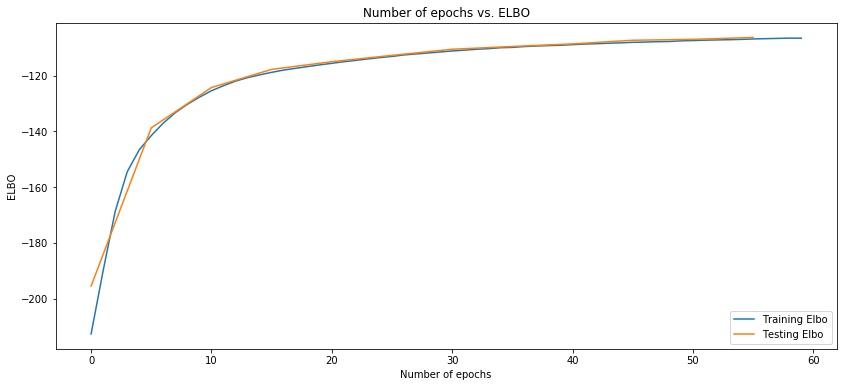

<Figure size 432x288 with 0 Axes>

In [38]:
# Plot ELBO
import matplotlib.pyplot as plt

xval1 = range(0,len(train_elbo)) # Number of training epochs
xval2 = range(0,len(train_elbo),TEST_FREQUENCY) # Number of testing epochs
plt.figure(figsize=(14,6)) # Control figure size
plt.plot(xval1, train_elbo,label = 'Training Elbo')
plt.plot(xval2, test_elbo ,label = 'Testing Elbo')
plt.title('Number of epochs vs. ELBO')
plt.xlabel('Number of epochs')
plt.ylabel('ELBO')
plt.legend(loc='lower right')
plt.show()
plt.savefig('Number of epochs vs. ELBO.png')

In [16]:
#This is the segment of the code that produces a feature vector. 
#We extract the feature vector from the first hidden layer.

z_loc, z_scale, features = vae.encoder.forward(train_loader.dataset[0][0].unsqueeze_(0))

#Since we are thinking about each vector as a probability distribution on the numbers 1, 2, 3... len(features), we want to normalize.
unscaled = np.array(features.tolist()[0])
scaled = unscaled / (sum(unscaled))
p = np.floor(scaled*1000)
p = p.astype(int).tolist()

length_feature_vector = len(p)


(60000, 32)

In [ ]:
#You must set the number of rows in the dataset you are running.
#We use 60000, which is the size of the training dataset.

nrows=60000

#This code produces a matrix with rows indexed by documents and columns by words.
#Equivalently, the rows are indexed by images, and the columns by features.
#This code could potentially be imporved by defining a sparse matrix.
doc_word = np.empty([nrows,length_feature_vector])
for i in range(nrows):
    z_loc, z_scale, features = vae.encoder.forward(train_loader.dataset[i][0].unsqueeze_(0))
    unscaled = np.array(features.tolist()[0])
    scaled = unscaled / (sum(unscaled))
    p = np.floor(scaled*1000)
    p =p.astype(int).tolist()
    doc_word[i] = p
    
doc_word = doc_word.astype(int)
np.shape(doc_word)



In [17]:
import lda 
from scipy.sparse import coo_matrix

data = doc_word

#Here you can change the number of topics, and the number of iterations. 1000 iterations with 30 topics takes about 3 hours.
model = lda.LDA(n_topics=20, n_iter=2000, random_state=1)
model.fit(data)

INFO:lda:n_documents: 60000
INFO:lda:vocab_size: 32
INFO:lda:n_words: 59060857
INFO:lda:n_topics: 20
INFO:lda:n_iter: 2000
INFO:lda:<0> log likelihood: -372229609
INFO:lda:<10> log likelihood: -349019776
INFO:lda:<20> log likelihood: -311171282
INFO:lda:<30> log likelihood: -289121568
INFO:lda:<40> log likelihood: -279945712
INFO:lda:<50> log likelihood: -275369916
INFO:lda:<60> log likelihood: -272654999
INFO:lda:<70> log likelihood: -270971895
INFO:lda:<80> log likelihood: -269835826
INFO:lda:<90> log likelihood: -269021058
INFO:lda:<100> log likelihood: -268421589
INFO:lda:<110> log likelihood: -267976548
INFO:lda:<120> log likelihood: -267581818
INFO:lda:<130> log likelihood: -267235998
INFO:lda:<140> log likelihood: -266971542
INFO:lda:<150> log likelihood: -266814733
INFO:lda:<160> log likelihood: -266560674
INFO:lda:<170> log likelihood: -266409793
INFO:lda:<180> log likelihood: -266176647
INFO:lda:<190> log likelihood: -266120521
INFO:lda:<200> log likelihood: -266024088
INFO:l

INFO:lda:<1910> log likelihood: -263405563
INFO:lda:<1920> log likelihood: -263365329
INFO:lda:<1930> log likelihood: -263386697
INFO:lda:<1940> log likelihood: -263430049
INFO:lda:<1950> log likelihood: -263432907
INFO:lda:<1960> log likelihood: -263462549
INFO:lda:<1970> log likelihood: -263483441
INFO:lda:<1980> log likelihood: -263350275
INFO:lda:<1990> log likelihood: -263401022
INFO:lda:<1999> log likelihood: -263413314


In [40]:
#This will list the most imortant features for each topic.

topic_word = model.topic_word_
n_top_words = 3
titles = np.array([str(i) for i in range(len(train_loader.dataset))])
vocab = np.array([str(i) for i in range(length_feature_vector)])

doc_word = doc_word.astype(int)
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: 29 10 9
Topic 1: 16 19 23
Topic 2: 10 23 8
Topic 3: 18 14 2
Topic 4: 2 20 12
Topic 5: 20 0 11
Topic 6: 2 15 0
Topic 7: 11 8 15
Topic 8: 10 2 27
Topic 9: 18 11 3
Topic 10: 10 2 11
Topic 11: 16 23 10
Topic 12: 28 11 18
Topic 13: 29 19 9
Topic 14: 20 6 12
Topic 15: 10 16 18
Topic 16: 10 0 13
Topic 17: 2 19 11
Topic 18: 14 9 18
Topic 19: 28 9 6


In [19]:
#Num_all is 10 lists. The first list contains the indices of all the zeros in the dataset, etc.
Num_all = [[] for i in range(10)]
doc_topic = model.doc_topic_

for i in range(10):
    for j in range(len(train_loader.dataset)):
        if train_loader.dataset[j][1]==i:
            Num_all[i]+=[doc_topic[j].argmax()]     

#distribution is a pseudo-confusion matrix, where the rows are indexed by the true of an image, and the columns by the assigned topic.
distribution = np.zeros([10,20])
for i,true_val in enumerate(Num_all):
    for j,pred_class in enumerate(Num_all[i]):
        distribution[i][pred_class]+=1
        
print(distribution.astype(int))

In [ ]:
#You can save the matrix to a .csv if you'd like
np.savetxt("lda_distribution.csv", distribution, delimiter=",")

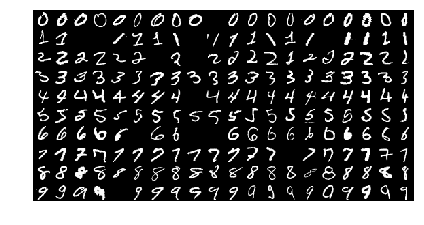

In [64]:
#This plots a sample from every entry in the confusion matrix.
canvas = np.zeros((28*len(distribution), 28*len(distribution[0])))

for k in range(len(distribution)):
    for i in range(len(distribution[0])):
        filled =False
        j=0
        while filled ==False and j < 60000:
            if doc_topic[j].argmax() == i and  train_loader.dataset[j][1]==k:
                filled =True
                canvas[28*k:28*(k+1),28*i:28*(i+1)] = train_loader.dataset[j][0].detach().reshape(28, 28)
            j+=1
            
plt.axis("off")        
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()        

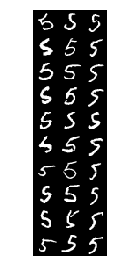

In [80]:
#Here you can explore the data by picking any number of topics, any digit, and looking at the first num_samples many instances.
topics_col = [0,13,5]
digit = 5
num_samples =10

canvas2 = np.zeros((28*num_samples, 28*len(topics_col)))

for i, index in enumerate(topics_col):
    j=0
    for k in range(num_samples):
        filled =False
        while filled ==False and j < 60000:
            if doc_topic[j].argmax() == index and  train_loader.dataset[j][1]==digit:
                filled =True
                canvas2[28*k:28*(k+1),28*i:28*(i+1)] = train_loader.dataset[j][0].detach().reshape(28, 28)
            j+=1
            
plt.axis("off")        
plt.imshow(canvas2, origin="upper", cmap="gray")
plt.tight_layout()        